<a href="https://colab.research.google.com/github/Onuchin-Artem/HiveRunner/blob/master/dl_lens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version
!pip install plydata
!pip install plotnine

Python 3.6.9
     |████████████████████████████████| 307kB 17.7MB/s 
     |████████████████████████████████| 10.1MB 50.4MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.0.5 which is incompatible.
  Found existing installation: pandas 1.1.4
    Uninstalling pandas-1.1.4:
      Successfully uninstalled pandas-1.1.4


In [1]:
import numpy as np
import pandas as pd
from plydata import *
from urllib.request import urlretrieve
import zipfile
# loading is take from  https://colab.research.google.com/github/google/eng-edu/blob/master/ml/recommendation-systems/recommendation-systems.ipynb?utm_source=ss-recommendation-systems&utm_campaign=colab-external&utm_medium=referral&utm_content=recommendation-systems

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')




Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


In [2]:
users = users >> mutate(user_id = "user_id - 1")
movies = movies >> mutate(movie_id = "movie_id - 1")
ratings = ratings  >> mutate(user_id = "user_id - 1", movie_id = "movie_id - 1")


In [3]:
users >> head(1)


,user_id,age,sex,occupation,zip_code
0,0,24,M,technician,85711


In [4]:
movies >> head(1)


,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
ratings >> head(1)

,user_id,movie_id,rating,unix_timestamp
0,195,241,3,881250949


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


train_ratings, test_ratings = train_test_split(ratings, test_size=0.1, random_state=42)

matrix_dimensions = ratings >> summarise(users_count = "n_distinct(user_id)",  movies_count = "n_distinct(movie_id)")

matrix_dimensions



,users_count,movies_count
0,943,1682


In [36]:
train_ratings >> summarise(mean_rating = "mean(rating)")

,mean_rating
0,3.530844


In [117]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F


class MatrixFactorization(nn.Module):
  def __init__(self, k, users_count, movies_count):
    super().__init__()
    self.users_embeddings = nn.Embedding(users_count, k)
    self.users_bias = nn.Embedding(users_count, 1)
    self.movies_embeddings = nn.Embedding(movies_count, k)
    self.movies_bias = nn.Embedding(movies_count, 1)
    nn.init.normal_(self.users_embeddings.weight, std=0.01)
    nn.init.normal_(self.movies_embeddings.weight, std=0.01)
    nn.init.normal_(self.users_bias.weight, std=0.5, mean=1.7)
    nn.init.normal_(self.movies_bias.weight, std=0.5, mean=1.7)



  def forward(self, user_ind, movie_ind):
    u_tensor = self.users_embeddings(user_ind)
    m_tensor = self.movies_embeddings(movie_ind)
    u_bias = self.users_bias(user_ind)
    m_bias = self.movies_bias(movie_ind)
    return torch.sum((u_tensor * m_tensor), axis=1) + torch.squeeze(u_bias) + torch.squeeze(m_bias)

device = torch.device("cuda:0")
loss_function = nn.MSELoss()
net = MatrixFactorization(k=50,
                          users_count=matrix_dimensions['users_count'][0],
                          movies_count=matrix_dimensions['movies_count'][0]).to(device)



adam = optim.Adam(net.parameters(), lr= 0.0001, weight_decay=0.0001)
train_loss = []
validation_loss = []

dataset = TensorDataset(
    torch.from_numpy(np.float32(train_ratings['rating'].values)), 
    torch.from_numpy(train_ratings['user_id'].values), 
    torch.from_numpy(train_ratings['movie_id'].values))

val_rating = torch.from_numpy(np.float32(test_ratings['rating'].values)).to(device)
val_user_ind = torch.from_numpy(test_ratings['user_id'].values).to(device)
val_movie_ind = torch.from_numpy(test_ratings['movie_id'].values).to(device)
loader = DataLoader(dataset, batch_size=1000)
epochs = range(100)
for epoch in epochs:
  for batch_idx, (rating, user_ind, movie_ind) in enumerate(loader):
    rating = rating.to(device)
    user_ind = user_ind.to(device)
    movie_ind = movie_ind.to(device)
    net.train()
    predicted_rating = net(user_ind, movie_ind)
    loss = loss_function(predicted_rating, rating)
    loss.backward()
    adam.step()
    net.zero_grad()
  train_loss.append(loss.item())
  with torch.no_grad():
    net.eval()
    val_predicted_rating = net(val_user_ind, val_movie_ind)
    val_loss = loss_function(val_predicted_rating, val_rating)
    validation_loss.append(val_loss.item())





In [118]:
loss


tensor(0.7819, device='cuda:0', grad_fn=<MseLossBackward>)

In [121]:
val_loss

tensor(0.8893, device='cuda:0')

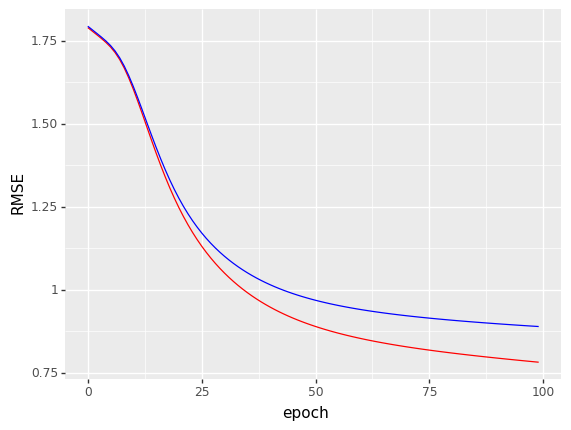

<ggplot: (-9223363253772599429)>

In [120]:
from plotnine import *
training_stats = pd.DataFrame({'epoch': epochs,
                   'train loss': train_loss,
                   'validation loss': validation_loss})

(ggplot(training_stats)
+ geom_line(aes(x="epoch", y="train loss"), color="red")
+ geom_line(aes(x="epoch", y="validation loss"), color="blue")
+ ylab("RMSE")
)